# Group 3: German Credit Case Study
By Aidan Franklin, Matthew Biddle, Josh  Tsutaoka, Hailey Nguyen

## Cell 1: Import Necessary Libraries
Imports essential Python libraries:

numpy: For numerical operations like arrays.

pandas: For data handling and manipulation.

matplotlib & seaborn: For creating visualizations.

scikit-learn modules: For machine learning tasks like model training, hyperparameter tuning, and performance evaluation.


In [79]:
# Import standard data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning libraries from scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
)
from sklearn.preprocessing import StandardScaler

# Import SMOTE for handling imbalanced datasets
from imblearn.over_sampling import SMOTE

# Import warnings to manage warning messages
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress non-critical warnings for cleaner output
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")


## Cell 2: Load and Explore the Dataset
Loads the dataset into a DataFrame using pandas:

Reads the CSV file containing the dataset.

Displays the first few rows using head() to examine the data’s structure, column names, and values.


In [81]:
def load_dataset(file_path):
    """
    Load the dataset from a CSV file.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - pd.DataFrame: Loaded dataset.
    """
    try:
        data = pd.read_csv(file_path)
        print(f"Dataset '{file_path}' loaded successfully.")
        return data
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_path}' was not found.")

def explore_dataset(data):
    """
    Display basic information, summary statistics, and the first few rows of the dataset.

    Parameters:
    - data (pd.DataFrame): The dataset to explore.

    Returns:
    - None
    """
    print("\n--- Dataset Information ---")
    print(data.info())  # Data types and non-null counts

    print("\n--- Summary Statistics ---")
    print(data.describe())  # Summary statistics for numerical features

    print("\n--- First 5 Rows of the Dataset ---")
    print(data.head())  # Display first few rows

# Specify the file path to the dataset
file_path = 'GermanCredit.csv'

# Load the dataset
data = load_dataset(file_path)

# Explore the dataset
explore_dataset(data)


Dataset 'GermanCredit.csv' loaded successfully.

--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   OBS#              1000 non-null   int64
 1   CHK_ACCT          1000 non-null   int64
 2   DURATION          1000 non-null   int64
 3   HISTORY           1000 non-null   int64
 4   NEW_CAR           1000 non-null   int64
 5   USED_CAR          1000 non-null   int64
 6   FURNITURE         1000 non-null   int64
 7   RADIO/TV          1000 non-null   int64
 8   EDUCATION         1000 non-null   int64
 9   RETRAINING        1000 non-null   int64
 10  AMOUNT            1000 non-null   int64
 11  SAV_ACCT          1000 non-null   int64
 12  EMPLOYMENT        1000 non-null   int64
 13  INSTALL_RATE      1000 non-null   int64
 14  MALE_DIV          1000 non-null   int64
 15  MALE_SINGLE       1000 non-null   int64
 16  MA

## Cell 3: Data Preprocessing
Separates the dataset into:

Features (X): Independent variables used to predict the target.

Target (y): Dependent variable the model will predict. Splits the data into training (70%) and testing (30%) subsets for model training and evaluation using train_test_split.


In [83]:
def preprocess_data(data, target_column='RESPONSE'):
    """
    Handle missing values, encode categorical variables, and separate features from target.

    Parameters:
    - data (pd.DataFrame): The raw dataset.
    - target_column (str): The name of the target variable.

    Returns:
    - X (pd.DataFrame): Feature set.
    - y (pd.Series): Target variable.
    - data_encoded (pd.DataFrame): Encoded and cleaned dataset.
    """
    # Handle missing values using forward fill
    data.ffill(inplace=True)
    print("Missing values handled using forward fill.")

    # Convert categorical variables into dummy variables
    data_encoded = pd.get_dummies(data, drop_first=True)
    print("Categorical variables encoded using one-hot encoding.")

    # Save the cleaned dataset for potential reuse
    cleaned_file = 'Cleaned_GermanCredit.csv'
    data_encoded.to_csv(cleaned_file, index=False)
    print(f"Cleaned dataset saved as '{cleaned_file}'.")

    # Verify if the target column exists
    if target_column in data_encoded.columns:
        X = data_encoded.drop(columns=[target_column])
        y = data_encoded[target_column]
        print(f"Features and target variable '{target_column}' separated.")
    else:
        raise ValueError(f"Target column '{target_column}' not found in the dataset.")

    return X, y, data_encoded

# Specify the target column
target_column = 'RESPONSE'  # Update if the target column name differs

# Preprocess the data
X, y, data_encoded = preprocess_data(data, target_column)


Missing values handled using forward fill.
Categorical variables encoded using one-hot encoding.
Cleaned dataset saved as 'Cleaned_GermanCredit.csv'.
Features and target variable 'RESPONSE' separated.


## Cell 4: Exploratory Data Analysis (Correlation Heatmap)
Applies feature scaling to normalize the feature values:

Uses StandardScaler to standardize all features to have a mean of 0 and a standard deviation of 1.

Scaling improves model performance, especially for algorithms sensitive to feature magnitudes.


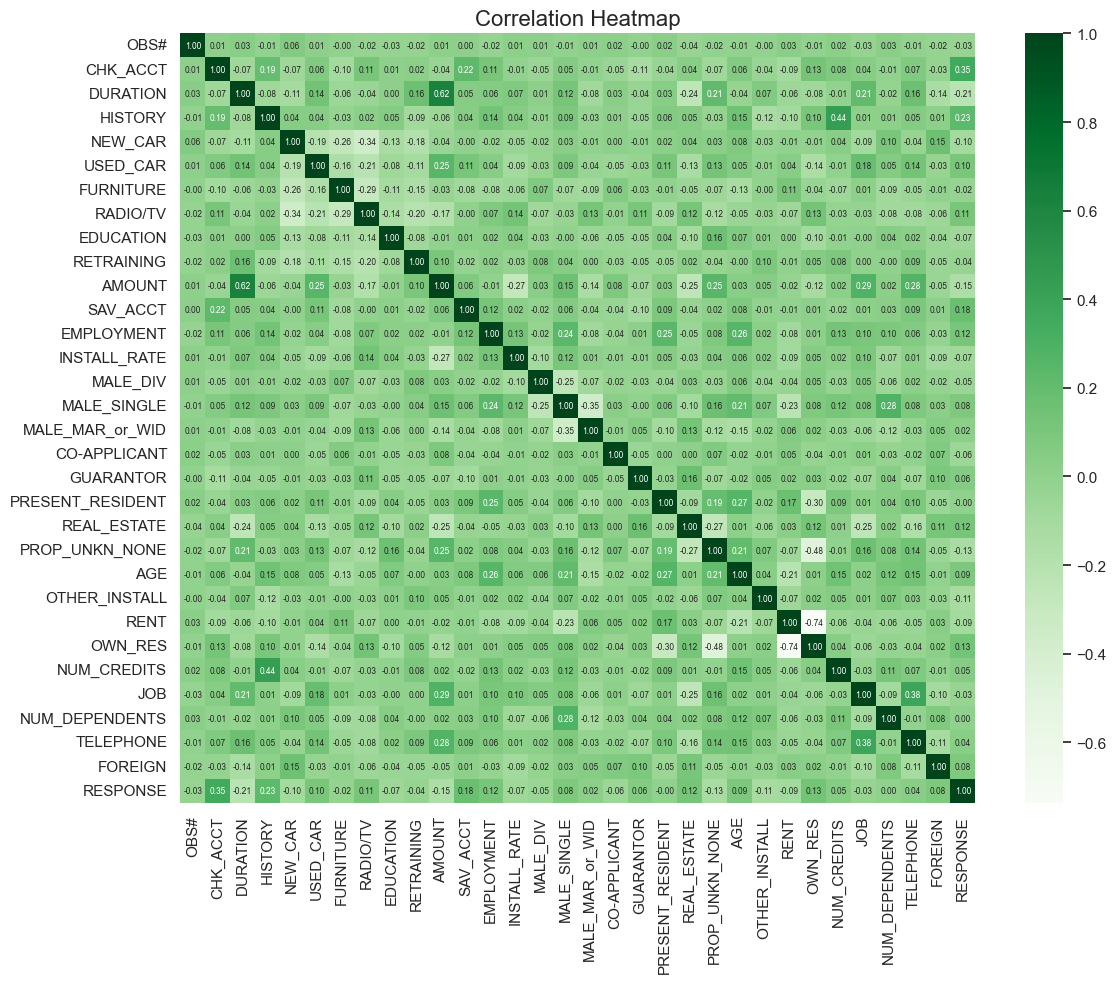

Correlation heatmap displayed.


In [85]:
def plot_correlation_heatmap(data_encoded):
    """
    Visualize the correlation matrix as a heatmap.

    Parameters:
    - data_encoded (pd.DataFrame): The encoded dataset.

    Returns:
    - None
    """
    plt.figure(figsize=(12, 10))
    correlation_matrix = data_encoded.corr()

    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="Greens", 
        cbar=True, 
        annot_kws={"size": 6}
    )
    plt.title("Correlation Heatmap", fontsize=16)
    plt.tight_layout()
    plt.show()
    print("Correlation heatmap displayed.")

# Plot the correlation heatmap
plot_correlation_heatmap(data_encoded)


## Cell 5: Data Splitting and Scaling
Trains a neural network using default hyperparameters:

The network consists of two hidden layers with 50 neurons each.

Uses the ReLU activation function and Adam optimizer.

After training, the network makes predictions on the test set, and accuracy is calculated to measure performance.


In [87]:
def split_and_scale(X, y, test_size=0.3, random_state=42):
    """
    Split the dataset into training and testing sets and apply standard scaling.

    Parameters:
    - X (pd.DataFrame): Feature set.
    - y (pd.Series): Target variable.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - X_train_scaled (np.ndarray): Scaled training features.
    - X_test_scaled (np.ndarray): Scaled testing features.
    - X_train (pd.DataFrame): Training features before scaling.
    - X_test (pd.DataFrame): Testing features before scaling.
    - y_train (pd.Series): Training target.
    - y_test (pd.Series): Testing target.
    - scaler (StandardScaler): Fitted scaler object.
    """
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=y
    )
    print(f"Data split into training and testing sets with test size = {test_size}.")

    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Feature scaling applied using StandardScaler.")

    return X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, scaler

# Split and scale the data
X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, scaler = split_and_scale(X, y)


Data split into training and testing sets with test size = 0.3.
Feature scaling applied using StandardScaler.


## Cell 6: Feature Selection (Top 5 Features by Correlation)
Uses GridSearchCV to optimize neural network hyperparameters:

Tests different configurations for hidden layers, activation functions, and maximum iterations.

Selects the best-performing configuration using cross-validation and returns the optimized model.


In [89]:
def select_top_features(data_encoded, target_column='RESPONSE', top_n=5):
    """
    Select the top N features based on their absolute correlation with the target variable.

    Parameters:
    - data_encoded (pd.DataFrame): The encoded dataset.
    - target_column (str): The name of the target variable.
    - top_n (int): Number of top features to select.

    Returns:
    - top_features (list): List of top feature names.
    """
    # Calculate absolute correlation with the target variable
    correlation_with_target = data_encoded.corr()[target_column].abs().sort_values(ascending=False)
    
    # Drop the target variable itself from the correlation calculation
    correlation_with_target = correlation_with_target.drop(labels=[target_column])
    
    # Select the top N features
    top_features = correlation_with_target.head(top_n).index.tolist()
    print(f"Top {top_n} Features by Correlation with '{target_column}': {top_features}")
    
    return top_features

# Select the top 5 features
top_features = select_top_features(data_encoded, target_column, top_n=5)

# Create datasets using only the top 5 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]
print("Datasets with top 5 features created.")


Top 5 Features by Correlation with 'RESPONSE': ['CHK_ACCT', 'HISTORY', 'DURATION', 'SAV_ACCT', 'AMOUNT']
Datasets with top 5 features created.


## Cell 7: Plot Top 5 Features by Correlation
Performs hyperparameter tuning for a decision tree:

Tests settings like maximum depth, splitting criteria (gini or entropy), and minimum samples required for a split.

The best model is selected based on cross-validation performance.


C:\Users\mbiddle\AppData\Local\Temp\ipykernel_9164\4244516254.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


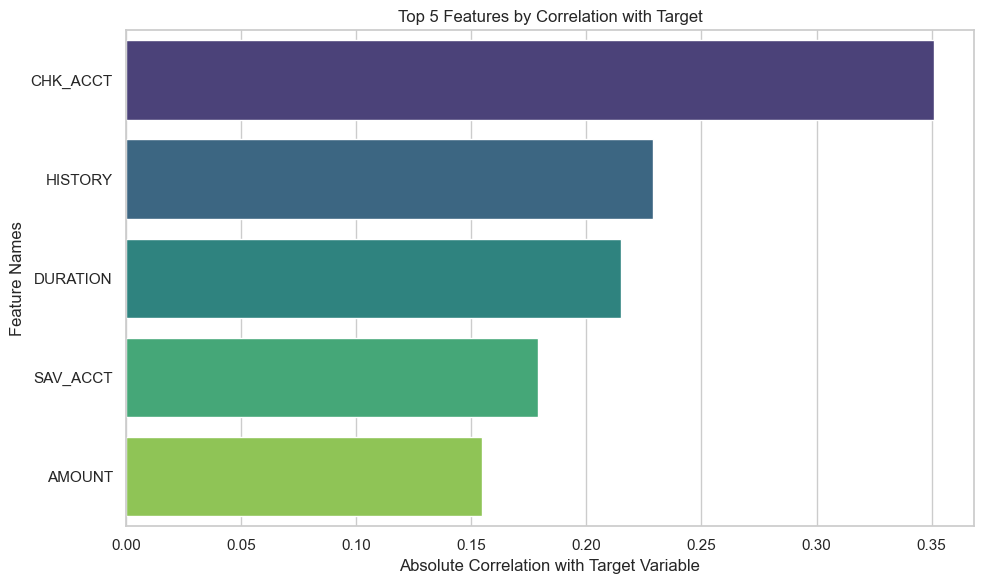

Bar chart for top 5 features displayed.


In [91]:
def plot_top_features(correlation_with_target, top_n=5):
    """
    Plot a horizontal bar chart of the top N features by correlation with the target variable.

    Parameters:
    - correlation_with_target (pd.Series): Correlation values with the target.
    - top_n (int): Number of top features to plot.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=correlation_with_target.values[:top_n], 
        y=correlation_with_target.index[:top_n], 
        palette='viridis'
    )
    plt.xlabel('Absolute Correlation with Target Variable')
    plt.ylabel('Feature Names')
    plt.title(f'Top {top_n} Features by Correlation with Target')
    plt.tight_layout()
    plt.show()
    print(f"Bar chart for top {top_n} features displayed.")

# Calculate absolute correlation with target for plotting
correlation_with_target = data_encoded.corr()[target_column].abs().sort_values(ascending=False).drop(labels=[target_column])

# Plot the top 5 features
plot_top_features(correlation_with_target, top_n=5)


## Cell 8: Hyperparameter Tuning for Neural Network (All Features)
Plots a confusion matrix for the neural network’s predictions:

Breaks down predictions into True Positives, True Negatives, False Positives, and False Negatives.

Visualizes the confusion matrix using a heatmap to highlight prediction performance.


In [93]:
def tune_neural_network(X_train_scaled, y_train):
    """
    Perform hyperparameter tuning for a Neural Network using GridSearchCV.

    Parameters:
    - X_train_scaled (np.ndarray): Scaled training features.
    - y_train (pd.Series): Training target.

    Returns:
    - best_nn_model (MLPClassifier): Best estimator found by GridSearchCV.
    - best_params (dict): Best hyperparameters.
    """
    # Define the parameter grid for the Neural Network
    nn_param_grid = {
        'hidden_layer_sizes': [(3,), (3, 4), (3, 4, 4), (50, 50)],
        'activation': ['logistic', 'relu'],
        'solver': ['adam'],
        'max_iter': [1000, 2000],
    }

    # Initialize GridSearchCV for Neural Network
    nn_grid = GridSearchCV(
        estimator=MLPClassifier(random_state=42),
        param_grid=nn_param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    print("Starting Neural Network hyperparameter tuning...")
    
    # Fit GridSearchCV
    nn_grid.fit(X_train_scaled, y_train)
    print("Neural Network hyperparameter tuning completed.")

    # Retrieve the best model and parameters
    best_nn_model = nn_grid.best_estimator_
    best_params = nn_grid.best_params_
    print(f"Best Neural Network Parameters: {best_params}")
    
    return best_nn_model, best_params

# Perform hyperparameter tuning for Neural Network using all features
best_nn_model_1a, best_params_nn_1a = tune_neural_network(X_train_scaled, y_train)

# Predict on the test set
y_pred_nn_1a = best_nn_model_1a.predict(X_test_scaled)

# Calculate and print accuracy
accuracy_nn_1a = accuracy_score(y_test, y_pred_nn_1a)
print(f"Neural Network Accuracy (All Features): {accuracy_nn_1a:.4f}")


Starting Neural Network hyperparameter tuning...
Neural Network hyperparameter tuning completed.
Best Neural Network Parameters: {'activation': 'relu', 'hidden_layer_sizes': (3,), 'max_iter': 1000, 'solver': 'adam'}
Neural Network Accuracy (All Features): 0.7100


## Cell 9: Hyperparameter Tuning for Decision Tree (All Features)
Similar to Cell 8, but plots the confusion matrix for the decision tree’s predictions:

Helps identify the decision tree’s prediction strengths and weaknesses.


In [95]:
def tune_decision_tree(X_train, y_train):
    """
    Perform hyperparameter tuning for a Decision Tree using GridSearchCV.

    Parameters:
    - X_train (pd.DataFrame): Training features before scaling.
    - y_train (pd.Series): Training target.

    Returns:
    - best_tree_model (DecisionTreeClassifier): Best estimator found by GridSearchCV.
    - best_params (dict): Best hyperparameters.
    """
    # Define the parameter grid for Decision Tree
    tree_param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4],
        'max_leaf_nodes': [10, 20, 30],
    }

    # Initialize GridSearchCV for Decision Tree
    tree_grid = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=42),
        param_grid=tree_param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    print("Starting Decision Tree hyperparameter tuning...")
    
    # Fit GridSearchCV
    tree_grid.fit(X_train, y_train)
    print("Decision Tree hyperparameter tuning completed.")

    # Retrieve the best model and parameters
    best_tree_model = tree_grid.best_estimator_
    best_params = tree_grid.best_params_
    print(f"Best Decision Tree Parameters: {best_params}")
    
    return best_tree_model, best_params

# Perform hyperparameter tuning for Decision Tree using all features
best_tree_model_1a, best_params_tree_1a = tune_decision_tree(X_train, y_train)

# Predict on the test set
y_pred_tree_1a = best_tree_model_1a.predict(X_test)

# Calculate and print accuracy
accuracy_tree_1a = accuracy_score(y_test, y_pred_tree_1a)
print(f"Decision Tree Accuracy (All Features): {accuracy_tree_1a:.4f}")


Starting Decision Tree hyperparameter tuning...
Decision Tree hyperparameter tuning completed.
Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree Accuracy (All Features): 0.7200


## Cell 10: Confusion Matrices for Models
Visualizes the structure of the decision tree:

Displays the splitting criteria and class predictions for each node.

Shows how the tree makes decisions, making it easy to interpret.


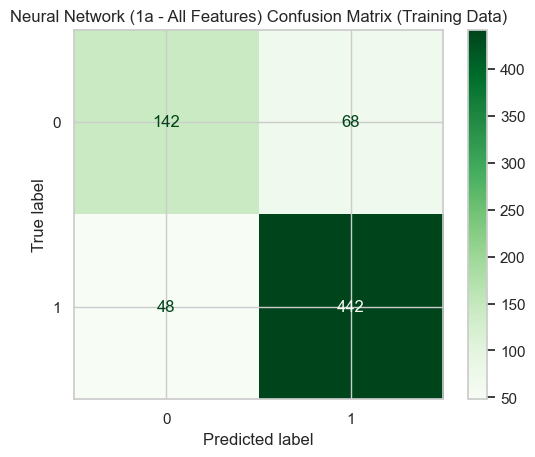

Confusion matrix for Neural Network (1a - All Features) (Training Data) displayed.


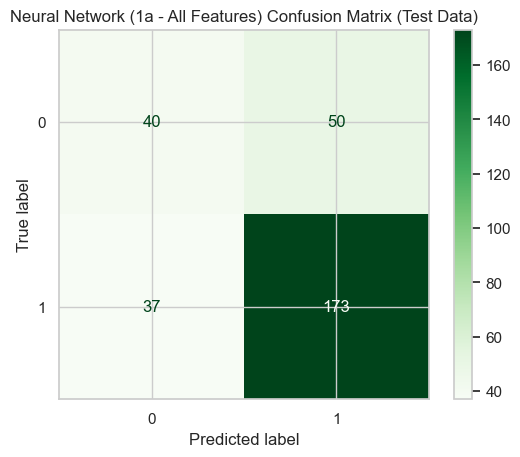

Confusion matrix for Neural Network (1a - All Features) (Test Data) displayed.


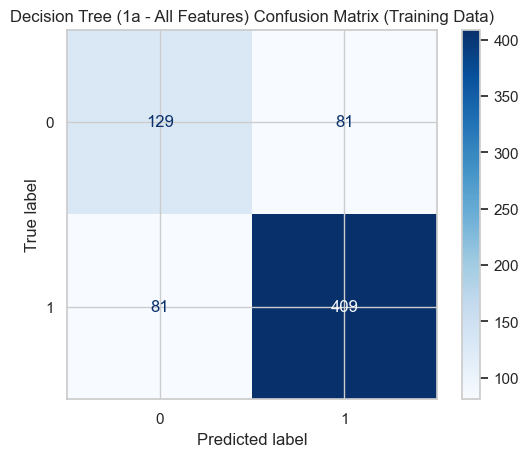

Confusion matrix for Decision Tree (1a - All Features) (Training Data) displayed.


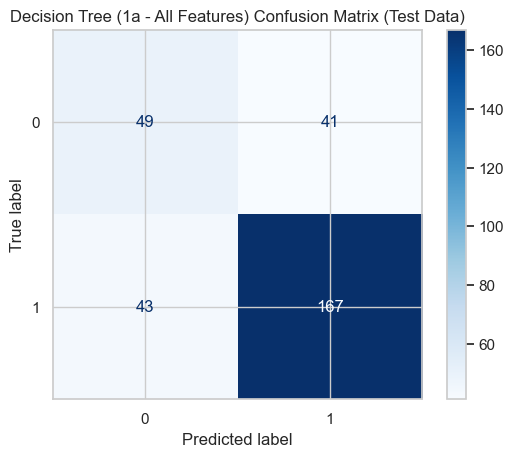

Confusion matrix for Decision Tree (1a - All Features) (Test Data) displayed.


In [97]:
def plot_confusion_matrix_display(y_true, y_pred, model_name, dataset_type="Test", cmap="Greens"):
    """
    Plot the confusion matrix for the given predictions.

    Parameters:
    - y_true (pd.Series): True labels.
    - y_pred (np.array): Predicted labels.
    - model_name (str): Name of the model.
    - dataset_type (str): 'Training' or 'Test' data.
    - cmap (str): Colormap for the heatmap.

    Returns:
    - None
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_true))
    disp.plot(cmap=cmap)
    plt.title(f"{model_name} Confusion Matrix ({dataset_type} Data)")
    plt.show()
    print(f"Confusion matrix for {model_name} ({dataset_type} Data) displayed.")

# Plot Confusion Matrix for Neural Network (1a - All Features) on Training Data
plot_confusion_matrix_display(
    y_true=y_train, 
    y_pred=best_nn_model_1a.predict(X_train_scaled), 
    model_name="Neural Network (1a - All Features)", 
    dataset_type="Training",
    cmap="Greens"
)

# Plot Confusion Matrix for Neural Network (1a - All Features) on Test Data
plot_confusion_matrix_display(
    y_true=y_test, 
    y_pred=y_pred_nn_1a, 
    model_name="Neural Network (1a - All Features)", 
    dataset_type="Test",
    cmap="Greens"
)

# Plot Confusion Matrix for Decision Tree (1a - All Features) on Training Data
plot_confusion_matrix_display(
    y_true=y_train, 
    y_pred=best_tree_model_1a.predict(X_train), 
    model_name="Decision Tree (1a - All Features)", 
    dataset_type="Training",
    cmap="Blues"
)

# Plot Confusion Matrix for Decision Tree (1a - All Features) on Test Data
plot_confusion_matrix_display(
    y_true=y_test, 
    y_pred=y_pred_tree_1a, 
    model_name="Decision Tree (1a - All Features)", 
    dataset_type="Test",
    cmap="Blues"
)


## Cell 11: Visualization of Decision Tree (Top 5 Features)
Generates a classification report for the neural network:

Provides metrics like precision, recall, F1-score, and support for each class.

Helps understand how well the model performs for each target class.


In [99]:
def visualize_decision_tree(model, feature_names, class_names, title):
    """
    Visualize the structure of a Decision Tree.

    Parameters:
    - model (DecisionTreeClassifier): Trained Decision Tree model.
    - feature_names (list): List of feature names.
    - class_names (list): List of class names.
    - title (str): Title of the plot.

    Returns:
    - None
    """
    plt.figure(figsize=(20, 10))
    plot_tree(
        model,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=12
    )
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    print(f"Decision Tree '{title}' visualized.")

## Cell 12: Visualization of Decision Tree (All Features)
Generates a classification report for the decision tree, similar to Cell 11:

Allows comparison between the neural network and decision tree performance.


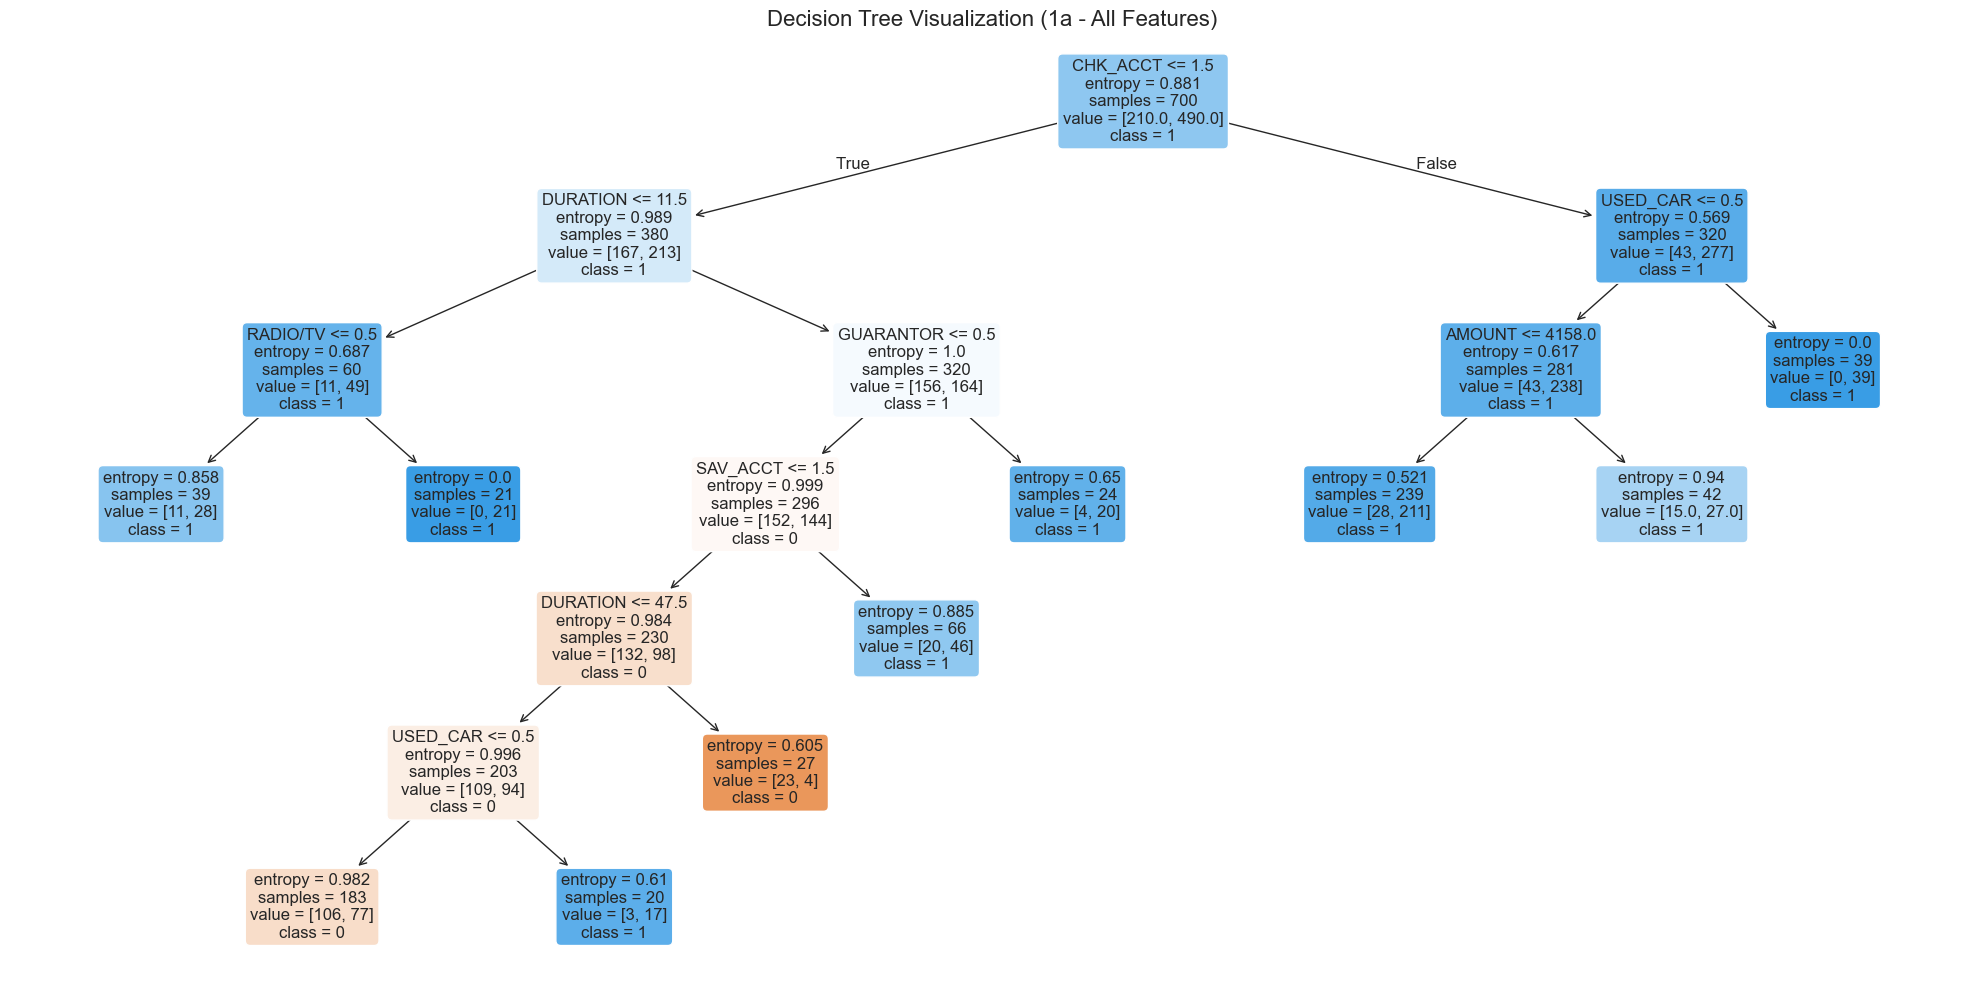

Decision Tree 'Decision Tree Visualization (1a - All Features)' visualized.


In [101]:
# Define class names based on unique target labels
class_names = [str(label) for label in np.unique(y)]

# Visualize the Decision Tree trained on all features
visualize_decision_tree(
    model=best_tree_model_1a,
    feature_names=X_train.columns.tolist(),
    class_names=class_names,
    title="Decision Tree Visualization (1a - All Features)"
)


## Cell 13: Define Cost/Gain Matrix and Calculate Net Profit
Calculates the net profit or loss for the neural network:

Multiplies the confusion matrix with a predefined cost-gain matrix.

Sums the resulting values to compute the total financial impact of the model’s predictions.


In [103]:
def calculate_net_profit(conf_matrix, cost_gain_matrix):
    """
    Calculate the net profit using the confusion matrix and cost/gain matrix.

    Parameters:
    - conf_matrix (np.ndarray): Confusion matrix of the model's predictions.
    - cost_gain_matrix (np.ndarray): Matrix defining the cost/gain for each outcome.

    Returns:
    - float: Net profit or loss.
    """
    net_profit = np.sum(conf_matrix * cost_gain_matrix)
    return net_profit

# Define the cost/gain matrix
# Format: [[Gain for TN, Cost for FP], [Cost for FN, Gain for TP]]
cost_gain_matrix = np.array([[50, -10], [-20, 100]])
print("Cost/Gain matrix defined.")

# Calculate net profit for Neural Network (1a - All Features)
conf_matrix_nn_1a = confusion_matrix(y_test, y_pred_nn_1a)
net_profit_nn_1a = calculate_net_profit(conf_matrix_nn_1a, cost_gain_matrix)
print(f"Neural Network (1a - All Features) Net Profit: ${net_profit_nn_1a:.2f}")

# Calculate net profit for Decision Tree (1a - All Features)
conf_matrix_tree_1a = confusion_matrix(y_test, y_pred_tree_1a)
net_profit_tree_1a = calculate_net_profit(conf_matrix_tree_1a, cost_gain_matrix)
print(f"Decision Tree (1a - All Features) Net Profit: ${net_profit_tree_1a:.2f}")


Cost/Gain matrix defined.
Neural Network (1a - All Features) Net Profit: $18060.00
Decision Tree (1a - All Features) Net Profit: $17880.00


## Cell 14: Visualization of Cost/Gain Matrices
Similar to Cell 13 but calculates profit or loss for the decision tree:

Helps determine the financial effectiveness of using a decision tree for predictions.


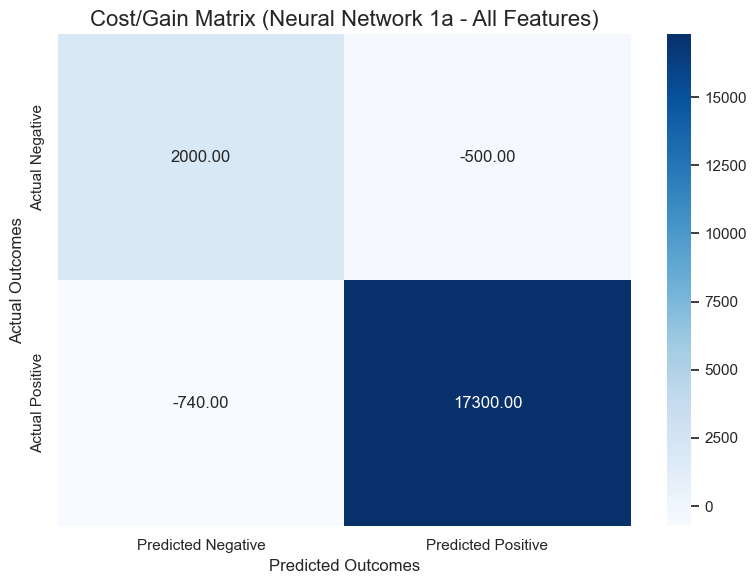

Cost/Gain matrix visualized for Cost/Gain Matrix (Neural Network 1a - All Features).


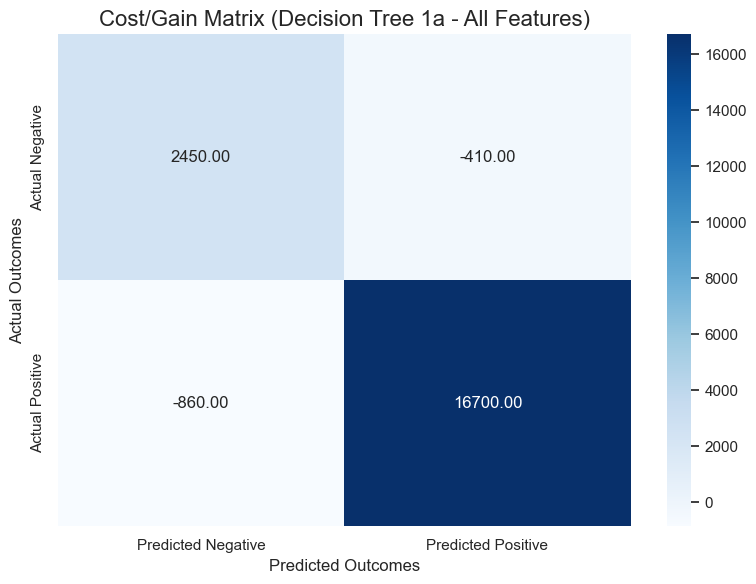

Cost/Gain matrix visualized for Cost/Gain Matrix (Decision Tree 1a - All Features).


In [105]:
def visualize_cost_gain_matrix(conf_matrix, cost_gain_matrix, title):
    """
    Visualize the cost/gain matrix as a heatmap.

    Parameters:
    - conf_matrix (np.ndarray): Confusion matrix of the model's predictions.
    - cost_gain_matrix (np.ndarray): Matrix defining the cost/gain for each outcome.
    - title (str): Title of the heatmap.

    Returns:
    - None
    """
    # Element-wise multiplication to compute the cost/gain values
    cost_gain_values = conf_matrix * cost_gain_matrix

    # Create a DataFrame for better visualization
    matrix_df = pd.DataFrame(
        cost_gain_values, 
        columns=["Predicted Negative", "Predicted Positive"], 
        index=["Actual Negative", "Actual Positive"]
    )

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix_df, annot=True, fmt=".2f", cmap="Blues", cbar=True)
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Outcomes")
    plt.ylabel("Actual Outcomes")
    plt.tight_layout()
    plt.show()
    print(f"Cost/Gain matrix visualized for {title}.")

# Visualize Cost/Gain Matrix for Neural Network (1a - All Features)
visualize_cost_gain_matrix(
    conf_matrix=conf_matrix_nn_1a, 
    cost_gain_matrix=cost_gain_matrix, 
    title="Cost/Gain Matrix (Neural Network 1a - All Features)"
)

# Visualize Cost/Gain Matrix for Decision Tree (1a - All Features)
visualize_cost_gain_matrix(
    conf_matrix=conf_matrix_tree_1a, 
    cost_gain_matrix=cost_gain_matrix, 
    title="Cost/Gain Matrix (Decision Tree 1a - All Features)"
)


## Cell 15: Classification Reports for Models
Performs hyperparameter tuning for a decision tree trained on a reduced set of important features:

Simplifies the model and reduces computation without sacrificing accuracy.

Focuses on the most relevant features for predictions.


In [107]:
def print_classification_report_custom(y_true, y_pred, model_name):
    """
    Print the classification report for the given predictions.

    Parameters:
    - y_true (pd.Series): True labels.
    - y_pred (np.ndarray): Predicted labels.
    - model_name (str): Name of the model.

    Returns:
    - None
    """
    report = classification_report(y_true, y_pred)
    print(f"\n--- Classification Report for {model_name} ---")
    print(report)

# Classification Report for Neural Network (1a - All Features)
print_classification_report_custom(
    y_true=y_test, 
    y_pred=y_pred_nn_1a, 
    model_name="Neural Network (1a - All Features)"
)

# Classification Report for Decision Tree (1a - All Features)
print_classification_report_custom(
    y_true=y_test, 
    y_pred=y_pred_tree_1a, 
    model_name="Decision Tree (1a - All Features)"
)



--- Classification Report for Neural Network (1a - All Features) ---
              precision    recall  f1-score   support

           0       0.52      0.44      0.48        90
           1       0.78      0.82      0.80       210

    accuracy                           0.71       300
   macro avg       0.65      0.63      0.64       300
weighted avg       0.70      0.71      0.70       300


--- Classification Report for Decision Tree (1a - All Features) ---
              precision    recall  f1-score   support

           0       0.53      0.54      0.54        90
           1       0.80      0.80      0.80       210

    accuracy                           0.72       300
   macro avg       0.67      0.67      0.67       300
weighted avg       0.72      0.72      0.72       300



## Cell 16: Hyperparameter Tuning for Decision Tree (Top 5 Features)
Tunes a neural network using only the top features:

Reduces input complexity by training the model on a subset of features.

Optimizes hyperparameters using GridSearchCV, similar to Cell 6.


In [109]:
# Reusing the tune_decision_tree function defined earlier

# Perform hyperparameter tuning for Decision Tree using top 5 features
best_tree_model_1b, best_params_tree_1b = tune_decision_tree(X_train_top, y_train)

# Predict on the test set
y_pred_tree_1b = best_tree_model_1b.predict(X_test_top)

# Calculate and print accuracy
accuracy_tree_1b = accuracy_score(y_test, y_pred_tree_1b)
print(f"Decision Tree Accuracy (Top 5 Features): {accuracy_tree_1b:.4f}")


Starting Decision Tree hyperparameter tuning...
Decision Tree hyperparameter tuning completed.
Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree Accuracy (Top 5 Features): 0.7167


## Cell 17: Hyperparameter Tuning for Neural Network (Top 5 Features)
Generates predictions on the training data for the optimized neural network:

Helps assess how well the model has learned from the training data.

Provides insights into potential overfitting.


In [111]:
def tune_neural_network_top_features(X_train_top, y_train):
    """
    Perform hyperparameter tuning for a Neural Network using top features.

    Parameters:
    - X_train_top (pd.DataFrame): Training features with top selected features.
    - y_train (pd.Series): Training target.

    Returns:
    - best_nn_model (MLPClassifier): Best estimator found by GridSearchCV.
    - best_params (dict): Best hyperparameters.
    """
    # Initialize the scaler for top features
    scaler_top = StandardScaler()
    X_train_top_scaled = scaler_top.fit_transform(X_train_top)
    X_test_top_scaled = scaler_top.transform(X_test_top)

    # Define the parameter grid
    nn_param_grid = {
        'hidden_layer_sizes': [(3,), (3, 4), (3, 4, 4), (50, 50)],
        'activation': ['logistic', 'relu'],
        'solver': ['adam'],
        'max_iter': [1000, 2000],
    }

    # Initialize GridSearchCV
    nn_grid = GridSearchCV(
        estimator=MLPClassifier(random_state=42),
        param_grid=nn_param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    print("Starting Neural Network hyperparameter tuning for Top 5 Features...")
    
    # Fit GridSearchCV
    nn_grid.fit(X_train_top_scaled, y_train)
    print("Neural Network hyperparameter tuning (Top 5 Features) completed.")

    # Retrieve the best model and parameters
    best_nn_model = nn_grid.best_estimator_
    best_params = nn_grid.best_params_
    print(f"Best Neural Network Parameters (Top 5 Features): {best_params}")
    
    # Predict on the test set
    y_pred_nn_1b = best_nn_model.predict(X_test_top_scaled)
    
    # Calculate accuracy
    accuracy_nn_1b = accuracy_score(y_test, y_pred_nn_1b)
    print(f"Neural Network Accuracy (Top 5 Features): {accuracy_nn_1b:.4f}")
    
    return best_nn_model, best_params, y_pred_nn_1b

# Perform hyperparameter tuning for Neural Network using top 5 features
best_nn_model_1b, best_params_nn_1b, y_pred_nn_1b = tune_neural_network_top_features(X_train_top, y_train)

Starting Neural Network hyperparameter tuning for Top 5 Features...
Neural Network hyperparameter tuning (Top 5 Features) completed.
Best Neural Network Parameters (Top 5 Features): {'activation': 'logistic', 'hidden_layer_sizes': (3, 4), 'max_iter': 1000, 'solver': 'adam'}
Neural Network Accuracy (Top 5 Features): 0.7767


## Cell 18: Generate Predictions and Plot Confusion Matrix for Neural Network (1b - Top 5 Features) on Training Data
Plots the confusion matrix for the neural network trained on top features:

Evaluates how well the simplified neural network performs compared to the full-feature model.


In [113]:
def plot_confusion_matrix_display(y_true, y_pred, model_name, dataset_type="Test", cmap="Greens"):
    """
    Plot the confusion matrix for the given predictions.

    Parameters:
    - y_true (pd.Series): True labels.
    - y_pred (np.ndarray): Predicted labels.
    - model_name (str): Name of the model.
    - dataset_type (str): 'Training' or 'Test' data.
    - cmap (str): Colormap for the heatmap.

    Returns:
    - None
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_true))
    disp.plot(cmap=cmap)
    plt.title(f"{model_name} Confusion Matrix ({dataset_type} Data)")
    plt.show()
    print(f"Confusion matrix for {model_name} ({dataset_type} Data) displayed.")

# Step 1: Scale the top 5 training features using the same scaler used during training
# It's crucial to use the same scaler to maintain consistency
# If you saved the scaler (`scaler_top_train`) during training, load it; otherwise, fit a new scaler here

# Assuming you did NOT save the scaler, fit a new scaler on the training data
scaler_top_train = StandardScaler()
X_train_top_scaled = scaler_top_train.fit_transform(X_train_top)
print("Training data scaled using StandardScaler.")

# Step 2: Generate predictions on the training data
y_pred_nn_train_1b = best_nn_model_1b.predict(X_train_top_scaled)
print("Predictions on Training Data for Neural Network (1b - Top 5 Features) generated.")


Training data scaled using StandardScaler.
Predictions on Training Data for Neural Network (1b - Top 5 Features) generated.


## Cell 19: Confusion Matrices for Models Using Top 5 Features
Plots the confusion matrix for the decision tree trained on top features:

Similar to Cell 18 but for the decision tree, allowing a comparison between models with reduced features.


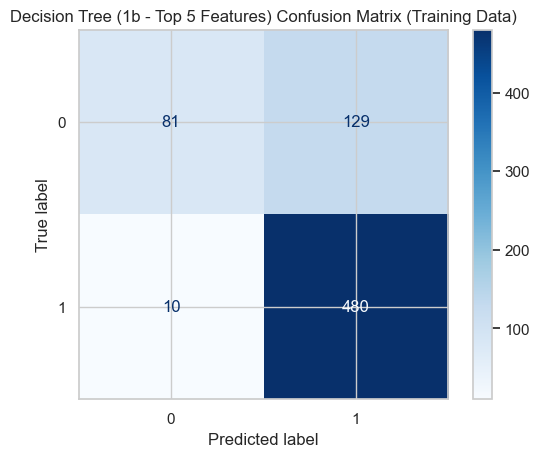

Confusion matrix for Decision Tree (1b - Top 5 Features) (Training Data) displayed.


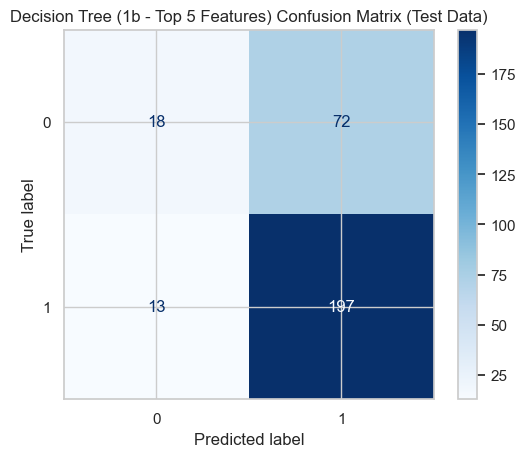

Confusion matrix for Decision Tree (1b - Top 5 Features) (Test Data) displayed.


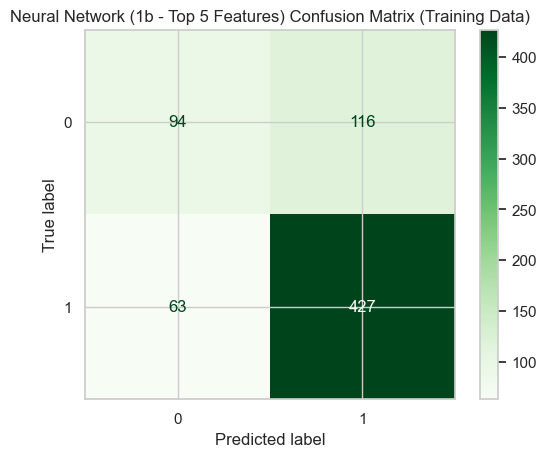

Confusion matrix for Neural Network (1b - Top 5 Features) (Training Data) displayed.


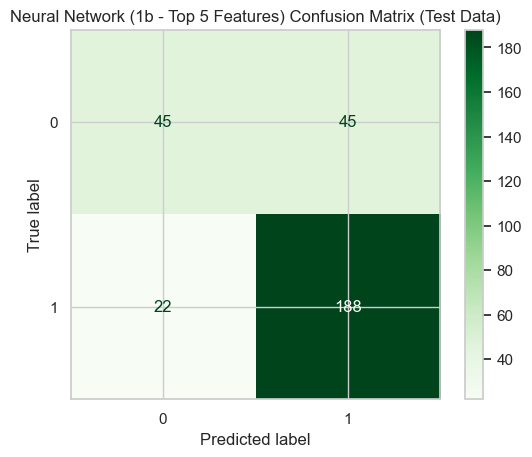

Confusion matrix for Neural Network (1b - Top 5 Features) (Test Data) displayed.


In [115]:
# Plot Confusion Matrix for Decision Tree (1b - Top 5 Features) on Training Data
plot_confusion_matrix_display(
    y_true=y_train, 
    y_pred=best_tree_model_1b.predict(X_train_top), 
    model_name="Decision Tree (1b - Top 5 Features)", 
    dataset_type="Training",
    cmap="Blues"
)

# Plot Confusion Matrix for Decision Tree (1b - Top 5 Features) on Test Data
plot_confusion_matrix_display(
    y_true=y_test, 
    y_pred=y_pred_tree_1b, 
    model_name="Decision Tree (1b - Top 5 Features)", 
    dataset_type="Test",
    cmap="Blues"
)

# Plot Confusion Matrix for Neural Network (1b - Top 5 Features) on Training Data
plot_confusion_matrix_display(
    y_true=y_train, 
    y_pred=y_pred_nn_train_1b, 
    model_name="Neural Network (1b - Top 5 Features)", 
    dataset_type="Training",
    cmap="Greens"
)

# Plot Confusion Matrix for Neural Network (1b - Top 5 Features) on Test Data
plot_confusion_matrix_display(
    y_true=y_test, 
    y_pred=y_pred_nn_1b, 
    model_name="Neural Network (1b - Top 5 Features)", 
    dataset_type="Test",
    cmap="Greens"
)


## Cell 20: Visualization of Decision Tree (Top 5 Features)
Visualizes the structure of the decision tree trained on top features:

A simpler tree that is easier to interpret and may generalize better than the full-feature model.


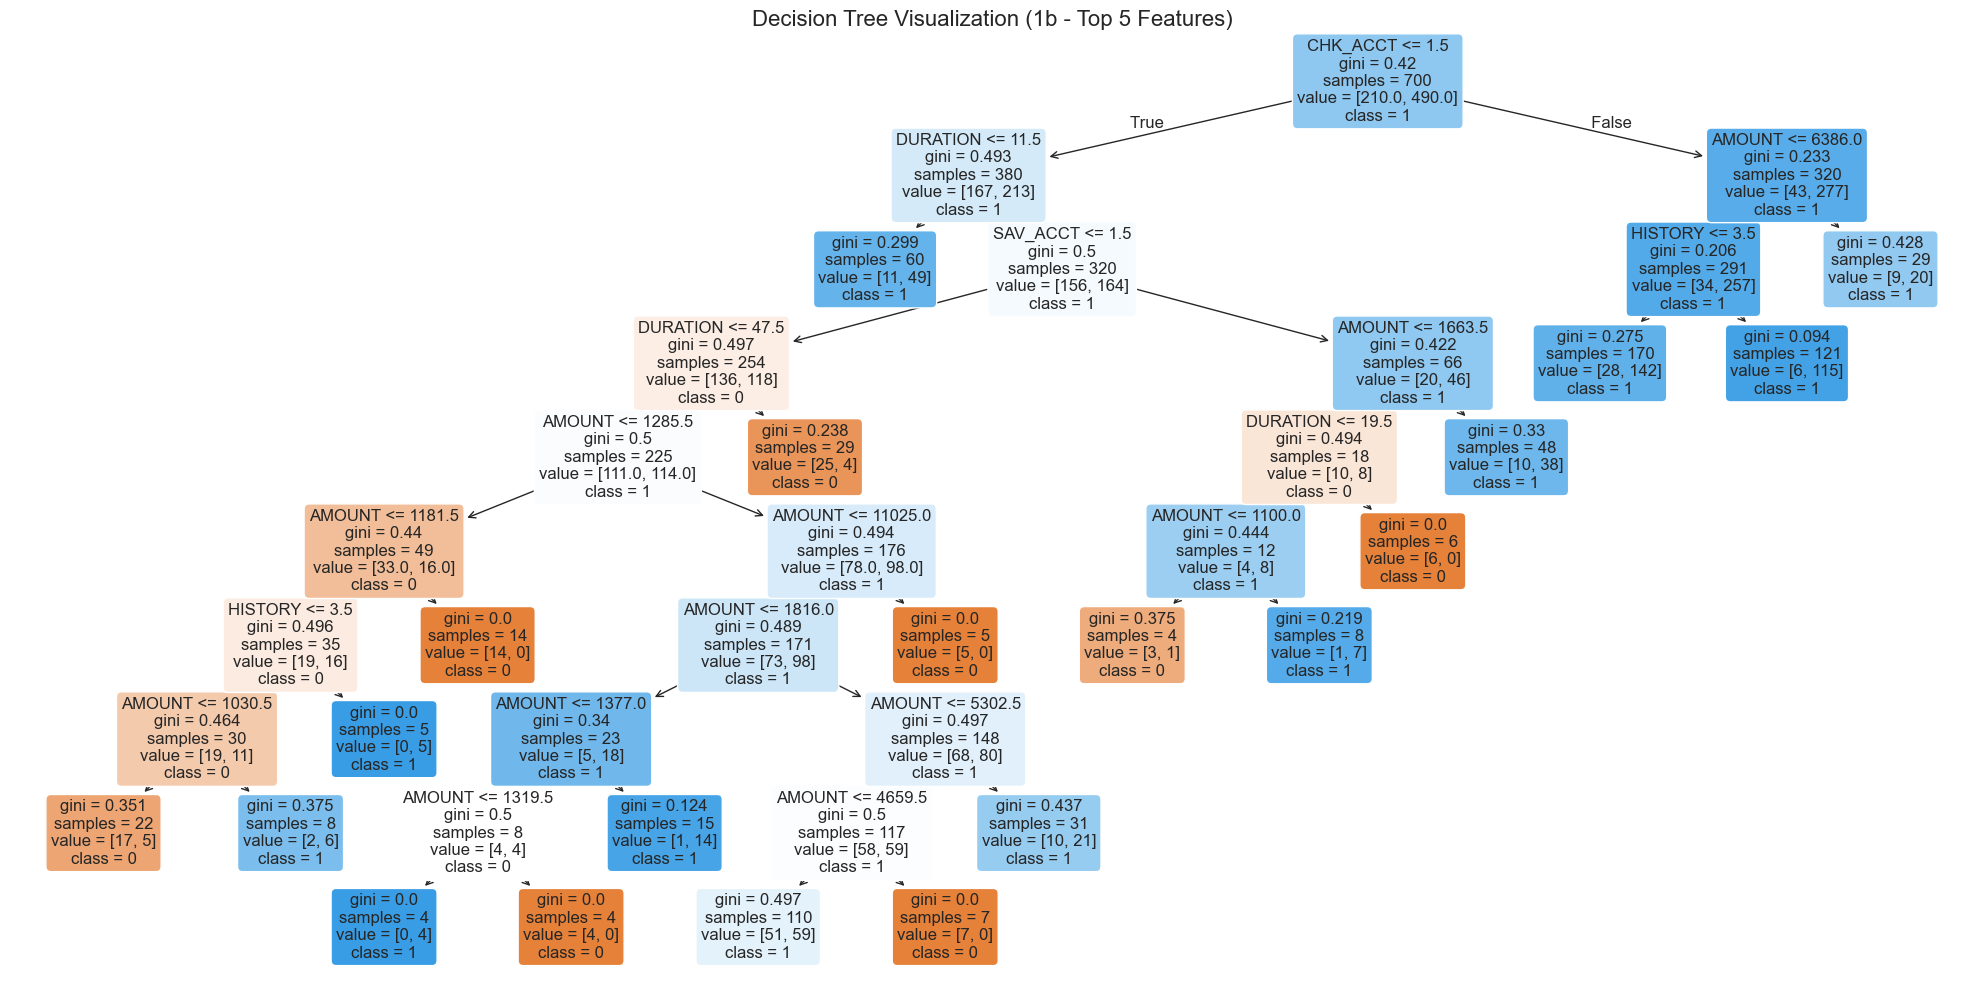

Decision Tree 'Decision Tree Visualization (1b - Top 5 Features)' visualized.


In [117]:
# Visualize the Decision Tree trained on top 5 features
visualize_decision_tree(
    model=best_tree_model_1b,
    feature_names=top_features,
    class_names=class_names,
    title="Decision Tree Visualization (1b - Top 5 Features)"
)


## Cell 21: Net Profit Calculations for All Models
Calculates and prints the net profit or loss for all models:

Compares neural network and decision tree models trained on all features and top features.

Evaluates models based on their financial impact.


In [119]:
# Function to calculate and print net profit
def calculate_and_print_net_profit(y_true, y_pred, model_name, cost_gain_matrix):
    """
    Calculate and print the net profit for a given model.

    Parameters:
    - y_true (pd.Series): True labels.
    - y_pred (np.ndarray): Predicted labels.
    - model_name (str): Name of the model.
    - cost_gain_matrix (np.ndarray): Cost/Gain matrix.

    Returns:
    - None
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    net_profit = calculate_net_profit(conf_matrix, cost_gain_matrix)
    print(f"{model_name} Net Profit: ${net_profit:.2f}")

# Calculate and print net profit for all models
calculate_and_print_net_profit(y_test, y_pred_nn_1a, "Neural Network (1a - All Features)", cost_gain_matrix)
calculate_and_print_net_profit(y_test, y_pred_nn_1b, "Neural Network (1b - Top 5 Features)", cost_gain_matrix)
calculate_and_print_net_profit(y_test, y_pred_tree_1a, "Decision Tree (1a - All Features)", cost_gain_matrix)
calculate_and_print_net_profit(y_test, y_pred_tree_1b, "Decision Tree (1b - Top 5 Features)", cost_gain_matrix)


Neural Network (1a - All Features) Net Profit: $18060.00
Neural Network (1b - Top 5 Features) Net Profit: $20160.00
Decision Tree (1a - All Features) Net Profit: $17880.00
Decision Tree (1b - Top 5 Features) Net Profit: $19620.00


## Cell 22: Visualization of Cost/Gain Matrices for All Models
Plots heatmaps for the cost-gain matrices of all models:

Highlights how each model’s predictions contribute to profit or loss.

Provides a visual comparison of the models’ financial outcomes.


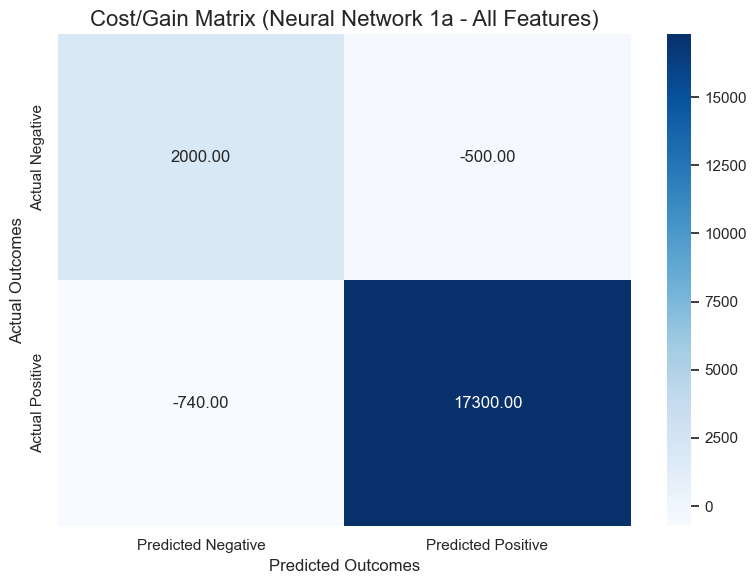

Cost/Gain matrix visualized for Cost/Gain Matrix (Neural Network 1a - All Features).


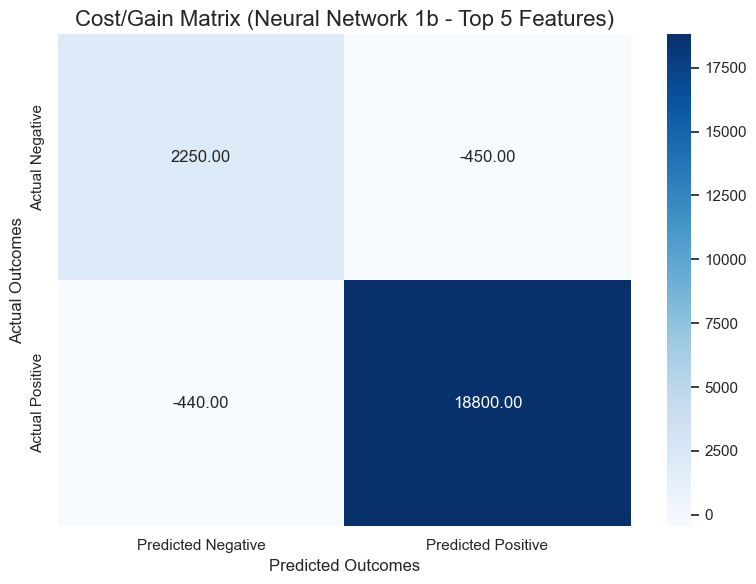

Cost/Gain matrix visualized for Cost/Gain Matrix (Neural Network 1b - Top 5 Features).


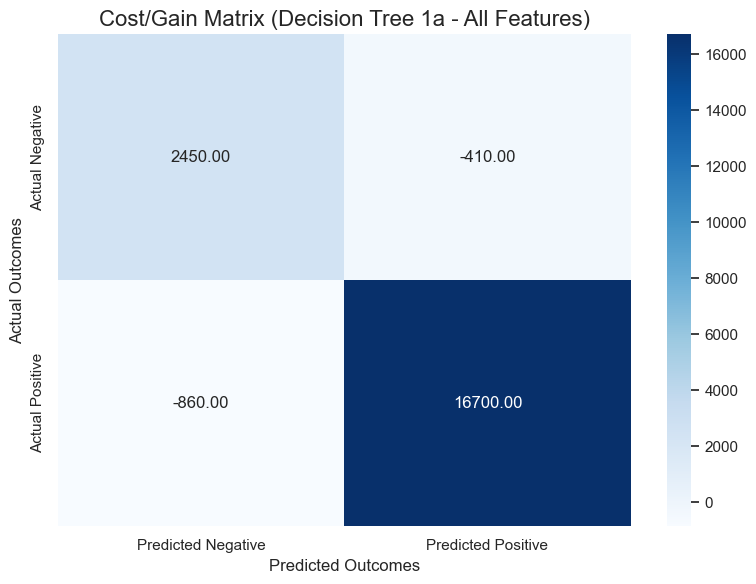

Cost/Gain matrix visualized for Cost/Gain Matrix (Decision Tree 1a - All Features).


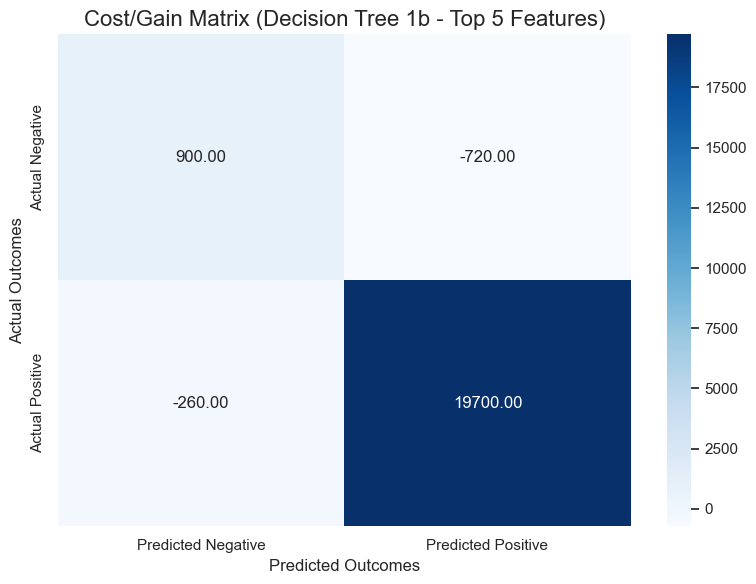

Cost/Gain matrix visualized for Cost/Gain Matrix (Decision Tree 1b - Top 5 Features).


In [121]:
# Visualize Cost/Gain Matrix for Neural Network (1a - All Features)
visualize_cost_gain_matrix(
    conf_matrix=conf_matrix_nn_1a, 
    cost_gain_matrix=cost_gain_matrix, 
    title="Cost/Gain Matrix (Neural Network 1a - All Features)"
)

# Visualize Cost/Gain Matrix for Neural Network (1b - Top 5 Features)
conf_matrix_nn_1b = confusion_matrix(y_test, y_pred_nn_1b)
visualize_cost_gain_matrix(
    conf_matrix=conf_matrix_nn_1b, 
    cost_gain_matrix=cost_gain_matrix, 
    title="Cost/Gain Matrix (Neural Network 1b - Top 5 Features)"
)

# Visualize Cost/Gain Matrix for Decision Tree (1a - All Features)
visualize_cost_gain_matrix(
    conf_matrix=conf_matrix_tree_1a, 
    cost_gain_matrix=cost_gain_matrix, 
    title="Cost/Gain Matrix (Decision Tree 1a - All Features)"
)

# Visualize Cost/Gain Matrix for Decision Tree (1b - Top 5 Features)
conf_matrix_tree_1b = confusion_matrix(y_test, y_pred_tree_1b)
visualize_cost_gain_matrix(
    conf_matrix=conf_matrix_tree_1b, 
    cost_gain_matrix=cost_gain_matrix, 
    title="Cost/Gain Matrix (Decision Tree 1b - Top 5 Features)"
)


## Cell 23: Classification Reports for All Models
Generates and prints classification reports for all models:

Summarizes precision, recall, and F1-scores for each class.

Finalizes the comparison of model performance, helping to decide which model to use.


In [123]:
# Print Classification Report for Neural Network (1a - All Features)
print_classification_report_custom(
    y_true=y_test, 
    y_pred=y_pred_nn_1a, 
    model_name="Neural Network (1a - All Features)"
)

# Print Classification Report for Neural Network (1b - Top 5 Features)
print_classification_report_custom(
    y_true=y_test, 
    y_pred=y_pred_nn_1b, 
    model_name="Neural Network (1b - Top 5 Features)"
)

# Print Classification Report for Decision Tree (1a - All Features)
print_classification_report_custom(
    y_true=y_test, 
    y_pred=y_pred_tree_1a, 
    model_name="Decision Tree (1a - All Features)"
)

# Print Classification Report for Decision Tree (1b - Top 5 Features)
print_classification_report_custom(
    y_true=y_test, 
    y_pred=y_pred_tree_1b, 
    model_name="Decision Tree (1b - Top 5 Features)"
)



--- Classification Report for Neural Network (1a - All Features) ---
              precision    recall  f1-score   support

           0       0.52      0.44      0.48        90
           1       0.78      0.82      0.80       210

    accuracy                           0.71       300
   macro avg       0.65      0.63      0.64       300
weighted avg       0.70      0.71      0.70       300


--- Classification Report for Neural Network (1b - Top 5 Features) ---
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        90
           1       0.81      0.90      0.85       210

    accuracy                           0.78       300
   macro avg       0.74      0.70      0.71       300
weighted avg       0.77      0.78      0.77       300


--- Classification Report for Decision Tree (1a - All Features) ---
              precision    recall  f1-score   support

           0       0.53      0.54      0.54        90
           1       0.80   

# Discussion Report

This classification report compares a neural network and a decision tree using all features and using only the top five features. It looks at accuracy, precision, recall, and F1-scores. It discusses assumptions, results, model strengths, limitations, and ethical considerations.

**Assumptions and Methods**

The neural network assumes complex patterns and tries to model them through layers of connected nodes. It benefits from having enough informative input variables. The decision tree uses a series of if-then rules. It splits data based on thresholds in features and tries to separate classes at each step.

We tested both models on the same dataset of 300 samples. The first experiment used all available features. The second experiment restricted inputs to the top five features, likely those deemed most predictive by some feature ranking method. By comparing these setups, we see how feature selection affects each model’s performance metrics.

**Results and Analysis**

For the neural network with all features, the accuracy was about 71%. Class 0 (90 samples) had a precision of 0.52 and recall of 0.44, while Class 1 (210 samples) had a precision of 0.78 and recall of 0.82. Reducing to top five features pushed accuracy to 78%, and Class 1 recall climbed to 0.90. Class 0 recall also improved from 0.44 to 0.50. The neural network gained from pruning features, focusing on those that matter most and dropping noise.

For the decision tree using all features, accuracy was 72%. Class 0 recall was 0.54 and Class 1 recall was 0.80. Precision for Class 0 was 0.53 and for Class 1 was 0.80. With top five features, the accuracy remained at 72%, but the model became skewed. Class 1 recall improved to 0.94, but Class 0 recall dropped sharply to 0.20. This indicates that the decision tree depended on a broader set of features. When forced to rely on fewer inputs, it favored the majority class and failed to identify Class 0 cases.

The classification report metrics show that the neural network adapted better to fewer inputs than the decision tree. The neural network’s weighted average F1-score rose from 0.70 to 0.77 when restricting features. The decision tree’s weighted average F1-score fell from 0.72 to 0.67 with fewer features. In short, the neural network maintained or improved balance between classes, while the decision tree became less balanced and overlooked a subset of instances.

**Strengths and Limitations**

The neural network proved flexible. With many features, it achieved a decent performance, and with fewer top features, it improved. It isolated key drivers of correct classification and leveraged them. However, neural networks can be harder to interpret. Understanding why a certain set of features improved performance can be non-trivial without additional analysis.

The decision tree was easy to interpret and did well when it had all the data. It achieved a fair balance, with both classes recognized. But it showed a limitation when forced to focus on a smaller set of inputs. Reducing the feature space made it lose sensitivity to Class 0. This weakness suggests that the decision tree model did not generalize well when key features were removed.

**Ethical Considerations**

When models misclassify certain groups more often, this can cause unfair outcomes. If Class 0 represents a minority class or a sensitive group, low recall means ignoring many individuals who belong to that group. The decision tree, when restricted to top features, exhibited a strong bias toward Class 1. This could have negative effects in real scenarios where balanced treatment matters.

The classification report shows that a shift in features changes how models treat different classes. This highlights the need for careful feature selection. Also, understanding the assumptions behind each method and the impact of data inputs on performance is key. Poorly chosen features can lead to biased decisions and harm certain populations. It is important to evaluate whether the selected features are fair, and monitor how changes in inputs affect the recognition of all groups.